In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [3]:
# read the pmi data
df = pd.read_csv('/content/drive/MyDrive/DeeP-PD/deep-pd/data/preprocessed/ppmi_modified.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,5,6,7,8,10,14,15,18,21,24,28,29,32,42,43,48,51,100,102,109,117,137,138,139,148,154,158,163,164,165,175,180,194,199,206,212,218,225,234,237,238,311,313,315,317,319,321,323,325,327,329,331,333,335,337,339,341,343,345,347,365,382,383,389,392,393,399,400,404,407,411,412,497,498,520,523,525,527,529,531,544,545,626,628,630,632,634,636,638,640,642,660,661,664,666,704,706,732,736,738,750,751,764,765,766,767,768,769,770,772,774,775,776,818,821,826,835,837,842,843,872,873,874,875,890,901,903,921,932,933,934,935,936,937,938,939,944,945,1034,1044,1054,1055,1057,1066,1067,1073,1076,1077,1079,1111,1112,1114,1156,1157,1159,1398,1399,1401,1416,1547,1549,1568,1569,1584,1585,1587,1637,1638,1640,1645,1652,1659,1666,1667,1669,1679,1681,1682,1683,1684,1686,1687,1688,1697,1698,1699,1700,1701,1707,1708,1709,1710,1711,1713,1714,1715,1716,1717,1719,1720,1721,1722,1723,1725,1726,1727,1728,1729,1731,1732,1733

In [4]:
from keras import Sequential
#from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
from sklearn.preprocessing import minmax_scale

# patient number
pat = df.patno
# moca score
moca = df.mcatot
mocaidx = ~(moca.isnull())
clincog = df.cogstate
clincogidx = ~(clincog.isnull())
#np1cog
npcog=df.np1cog
npcogidx = ~(npcog.isnull())
#npcog[npcog>0] = 1

#PD status
pdstatus=df.apprdx
pdstatusidx= ~(pdstatus.isnull())

# delta_visit
delta_visit=df.delta_visit
# years with PD
pddxdt=df.pddxdt
pddxdt = pddxdt.replace(np.nan, 0) #comment as needed
pddxdtidx= ~(pddxdt.isnull())
pddxdtyear=pd.DatetimeIndex(pddxdt).year.values
pddxdtmonth=pd.DatetimeIndex(pddxdt).month.values
infodt=df.infodt
infodtidx= ~(infodt.isnull())
infodtyear=pd.DatetimeIndex(infodt).year.values
infodtmonth=pd.DatetimeIndex(infodt).month.values


years_pd = np.zeros(len(pddxdt))*float("NaN")
for i in range(len(years_pd)):
    if pddxdtidx[i] & infodtidx[i]:
      if pddxdtyear[i] ==0:
        years_pd[i]=0
      else:
        pdd_year=int(pddxdtyear[i]) 
        pdd_month=int(pddxdtmonth[i])
        visit_year=int(infodtyear[i])
        visit_month=int(infodtmonth[i])
        temp = (visit_year - pdd_year) * 12 + visit_month - pdd_month
        if temp > 0:
          years_pd[i]=temp
        else:
          years_pd[i]=0


educ = df.educyrs
educidx = ~(educ.isnull())

#bday
bdt = df.birthdt
bdtidx = ~(bdt.isnull())
bdtyear =pd.DatetimeIndex(bdt).year.values

#date of moca
mocadt = df.infodt
mocadtidx = ~(mocadt.isnull())

symdig = df.sdmtotal
symdigidx = ~(symdig.isnull())

sex = df.gender
sexidx = ~(sex.isnull())

#age at moca
age = np.zeros(len(moca))*float("NaN")
for i in range(len(age)):
    if mocadtidx[i] & bdtidx[i]:
        age[i] = int(infodtyear[i]) - bdtyear[i]


patno = df.patno
patidx = ~(patno.isnull())
eventid=df.event_id
eventidx=~(eventid.isnull())

# weight and height for BMI index
weight=df.wgtkg
weightidx=~(weight.isnull())
height=df.htcm
heightidx=~(height.isnull())

# supine blood pressure 
syssup=df.syssup
syssupidx=~(syssup.isnull())
diasup=df.diasup
diasupidx=~(diasup.isnull())

# standing blood pressure 
sysstnd=df.sysstnd
sysstndidx=~(sysstnd.isnull())
diastnd=df.diastnd
diastndidx=~(diastnd.isnull())

#Schwab and England activities
mseadlg=df.mseadlg
mseadlgidx=~(mseadlg.isnull())

#TD/PIGD scores
tremor_score=df.tremor_score
tremor_scoreidx=~(tremor_score.isnull())
pigd_score=df.pigd_score
pigd_scoreidx=~(pigd_score.isnull())
td_pigd_ratio=df.td_pigd_ratio
td_pigd_ratioidx=~(td_pigd_ratio.isnull())
td_pigd_ratio[td_pigd_ratio=='inf']=99
td_pigd_class=df.td_pigd_class
td_pigd_classidx=~(td_pigd_class.isnull())
td_pigd_class[td_pigd_class=='td']=0
td_pigd_class[td_pigd_class=='pigd']=1
td_pigd_class[td_pigd_class=='indeterminate']=2

clinscor = df.cogdxcl
clinscoridx1 = clinscor<2.0
#idx= npcogidx & mocaidx & sexidx & bdtidx & educidx & mocadtidx & weightidx & heightidx & mseadlgidx & clincogidx & clinscoridx1 & pdstatusidx & pddxdtidx & infodtidx &  tremor_scoreidx & pigd_scoreidx & td_pigd_class
idx= npcogidx & mocaidx  & sexidx & bdtidx & educidx & mocadtidx & mseadlgidx & clincogidx #& clinscoridx1
bmi=weight[idx]/(height[idx]*10**-2)**2
data = np.stack((moca[idx],npcog[idx],age[idx],educ[idx],sex[idx],mseadlg[idx],clincog[idx],eventid[idx],patno[idx],delta_visit[idx],),1)
params=6
data1=pd.DataFrame(data).drop_duplicates().values
data2 = np.delete(data1, np.s_[params:params+4], 1)
data3 = np.delete(data1, np.s_[0:params+2], 1)
data4 = data1[:,params].reshape(np.shape(data1)[0],1)
#min-max feature normalization
#data2 = minmax_scale(data2, feature_range=(0,1), axis=0)
#max normalization
data2= data2 / data2.max(axis=0)
data1=np.concatenate((data2, data3, data4), axis=1)
#data=np.zeros(np.shape(np.unique(data1[:,10]))[0],)
data=[]
labels=[]   #one-hot encoded labels
labels_true=[] #
patients=[]

count=0
parameters=params
count0=0
count1=0
count2=0
for i in np.unique(patno[idx]):
  temp=data1[np.where(data1[:,parameters] == i)]
  temp = temp[np.argsort(temp[:, parameters+1])]
  
  if np.shape(temp)[0]>1:
    for j in range(np.shape(temp)[0]-1):
      # previous visit features
      temp1=temp[j,:parameters].astype(float)
      temp_pat=temp[j,parameters]
      #previous visit labels
      temp2=temp[j,parameters+2]
      temp_previouslabel=np.zeros((1,3))
      temp_previouslabel[0,int(temp2)-1]=1
      features=np.concatenate((np.reshape(temp1,(1,np.shape(temp1)[0])), temp_previouslabel), axis=1)
      #add the visit index so that later we can analysis how model performs for each visit seprartely
      features = np.append(features, j).reshape(1,np.shape(features)[1]+1)


      data.append(features)
      patients.append(temp_pat)
      # next visit target label
      target=temp[j+1,parameters+2]
      if target==1:
        count0=count0+1
      elif target==2:
        count1=count1+1
      elif target==3:
        count2=count2+1
      temp_nextlabel=np.zeros((1,3))
      temp_nextlabel[0,int(target)-1]=1
      labels.append(temp_nextlabel)
      labels_true.append(target-1)
 # for x,s in enumerate(target):
 #   temp_label[x,int(s)-1]=1
 # seq_len=np.shape(target)[0]
 # if count==0:
 #   max_seq_len=seq_len
 # if seq_len >= max_seq_len:
 #   max_seq_len=seq_len
#labels.append(temp_label)
#count=count+1
#data=np.asarray(data)
#patients=np.asarray(patients)
#labels=np.asarray(labels)
#labels=np.reshape(labels,(np.shape(labels)[0],3))
#labels = array(labels).reshape(labels.shape[0], max_seq_len, 3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying 

In [ ]:
np.shape(np.where(np.asarray(labels_true)==2))[1]
#2041+122+37
#len(labels_true)

76

In [ ]:
np.shape(labels_true)

(3086,)

In [5]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 679 kB 7.5 MB/s 


In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
def custom_f12(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+0.0000001)    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+0.0000001)
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+0.0000001))

def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
        Positives = np.sum(np.round(np.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+0.0000001)    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+0.0000001)
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+0.0000001))

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """  
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, 0.0000001, 1-0.0000001 )
        # calc
        loss = y_true * K.log(y_pred+0.0000001) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

def loss_np(y_true, y_pred, weights): 
  # scale predictions so that the class probas of each sample sum to 1
  #weights=K.variable(weights)
  y_pred /= np.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
  y_pred = np.clip(y_pred, 0.0000001, 1-0.0000001 )
        # calc
  loss = y_true * np.log(y_pred+0.0000001) * weights
  loss = -np.sum(loss, -1)
  return loss
from tensorflow.keras.callbacks import Callback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, f1, acc = self.model.evaluate(x, y, verbose=0)
        loss_test.append(loss)
        f1_test.append(f1)
        acc_test.append(acc)
        print('\nTesting loss: {}, custom_f1: {}, acc: {}\n'.format(loss, f1, acc))

def f1_weighted(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = K.sum(true, axis=0) + 0.0000001       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + 0.0000001         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + 0.0000001  # = TP
        #all with shape (4,)
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + 0.0000001)
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)

    
    return weighted_f1 #for metrics, return only 'weighted_f1'

def f1_weighted_np(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = np.sum(true, axis=0) + 0.0000001      # = TP + FN
    pred_positives = np.sum(pred, axis=0) + 0.0000001         # = TP + FP
    true_positives = np.sum(true * pred, axis=0) + 0.0000001  # = TP
        #all with shape (4,)
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + 0.0000001)
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / np.sum(ground_positives) 
    weighted_f1 = np.sum(weighted_f1)

    
    return weighted_f1 #for metrics, return only 'weighted_f1'

In [ ]:
# implement k-fold cross validation

In [7]:
# fit sequential models
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
tf. device("gpu:1")
from keras.metrics import Precision, Recall
#yhat = model.predict_classes(X_test1)
#yhat = model.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import pylab as pl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

acc1_train = []
f11_train = []

acc1_valid = []
f11_valid = []

acc1_test = []
f11_test = []
acc1_test_first=[]
f11_test_first=[]
acc1_test_second=[]
f11_test_second=[]
acc1_test_third=[]
f11_test_third=[]
acc1_test_fourth=[]
f11_test_fourth=[]
acc1_test_fifth=[]
f11_test_fifth=[]
acc1_test_sixth=[]
f11_test_sixth=[]
acc1_test_seventh=[]
f11_test_seventh=[]

acc1_statuschange0_1=[]
f11_statuschange0_1=[]
acc1_statuschange0_2=[]
f11_statuschange0_2=[]
acc1_statuschange1_2=[]
f11_statuschange1_2=[]
acc1_statuschange1_0=[]
f11_statuschange1_0=[]
acc1_statuschange2_1=[]
f11_statuschange2_1=[]
n=1


In [8]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Epoch 1/50
2217/2217 [==============================] - 9s 3ms/step - loss: 0.3309 - custom_f12: 0.5650 - acc: 0.7764 - val_loss: 0.7131 - val_custom_f12: 0.7733 - val_acc: 0.8421

Epoch 00001: saving model to mymodel_1.h5

Epoch 00001: val_custom_f12 improved from -inf to 0.77328, saving model to best_model.h5

Testing loss: 0.7593967318534851, custom_f1: 0.813937783241272, acc: 0.827974259853363

Epoch 2/50
2217/2217 [==============================] - 7s 3ms/step - loss: 0.2217 - custom_f12: 0.7783 - acc: 0.8610 - val_loss: 0.6576 - val_custom_f12: 0.7733 - val_acc: 0.8462

Epoch 00002: saving model to mymodel_2.h5

Epoch 00002: val_custom_f12 did not improve from 0.77328

Testing loss: 0.7124524116516113, custom_f1: 0.813937783241272, acc: 0.8327974081039429

Epoch 3/50
2217/2217 [==============================] - 7s 3ms/step - loss: 0.2082 - custom_f12: 0.7942 - acc: 0.8559 - val_loss: 0.6373 - val_custom_f12: 0.8138 - val_acc: 0.8502

Epoch 00003: saving model to mymodel_3.h5

Epo

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

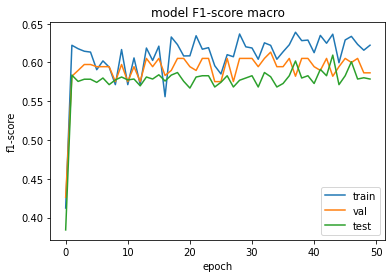

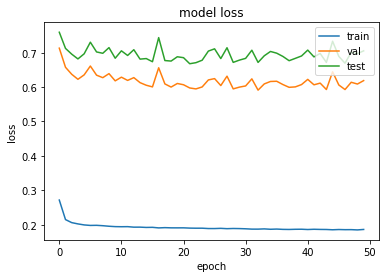

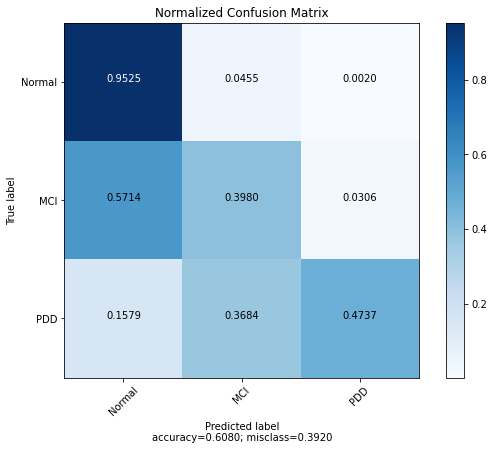

Epoch 1/50
2221/2221 [==============================] - 9s 3ms/step - loss: 0.3375 - custom_f12: 0.5159 - acc: 0.7306 - val_loss: 0.7051 - val_custom_f12: 0.7935 - val_acc: 0.8178

Epoch 00001: saving model to mymodel_1.h5

Epoch 00001: val_custom_f12 improved from -inf to 0.79352, saving model to best_model.h5

Testing loss: 0.6697983145713806, custom_f1: 0.8400270342826843, acc: 0.844660222530365

Epoch 2/50
2221/2221 [==============================] - 7s 3ms/step - loss: 0.2278 - custom_f12: 0.8021 - acc: 0.8539 - val_loss: 0.6826 - val_custom_f12: 0.8097 - val_acc: 0.8219

Epoch 00002: saving model to mymodel_2.h5

Epoch 00002: val_custom_f12 improved from 0.79352 to 0.80972, saving model to best_model.h5

Testing loss: 0.6480507254600525, custom_f1: 0.8420423269271851, acc: 0.8478964567184448

Epoch 3/50
2221/2221 [==============================] - 7s 3ms/step - loss: 0.2085 - custom_f12: 0.8630 - acc: 0.8741 - val_loss: 0.6829 - val_custom_f12: 0.7814 - val_acc: 0.8178

Epoch 000

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

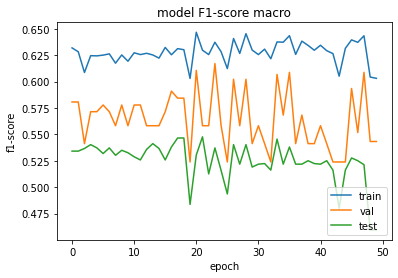

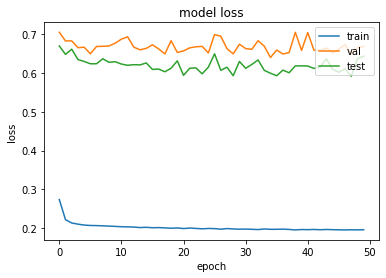

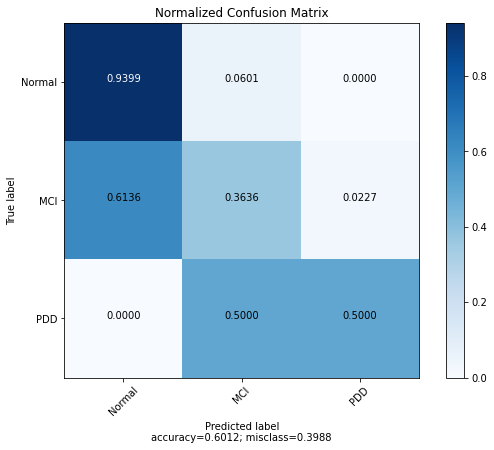

Epoch 1/50
2224/2224 [==============================] - 9s 3ms/step - loss: 0.3236 - custom_f12: 0.5913 - acc: 0.8060 - val_loss: 0.7501 - val_custom_f12: 0.7823 - val_acc: 0.8185

Epoch 00001: saving model to mymodel_1.h5

Epoch 00001: val_custom_f12 improved from -inf to 0.78226, saving model to best_model.h5

Testing loss: 0.7498181462287903, custom_f1: 0.8445558547973633, acc: 0.8273615837097168

Epoch 2/50
2224/2224 [==============================] - 7s 3ms/step - loss: 0.2605 - custom_f12: 0.7677 - acc: 0.8080 - val_loss: 0.7327 - val_custom_f12: 0.7581 - val_acc: 0.8185

Epoch 00002: saving model to mymodel_2.h5

Epoch 00002: val_custom_f12 did not improve from 0.78226

Testing loss: 0.7427985072135925, custom_f1: 0.8412206768989563, acc: 0.8273615837097168

Epoch 3/50
2224/2224 [==============================] - 7s 3ms/step - loss: 0.2433 - custom_f12: 0.7624 - acc: 0.8264 - val_loss: 0.6952 - val_custom_f12: 0.7581 - val_acc: 0.8669

Epoch 00003: saving model to mymodel_3.h5



/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

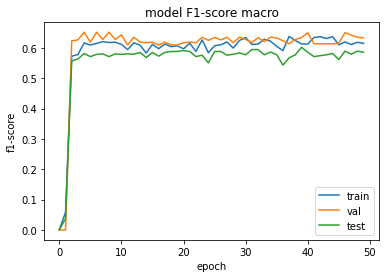

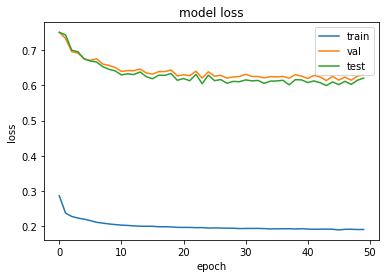

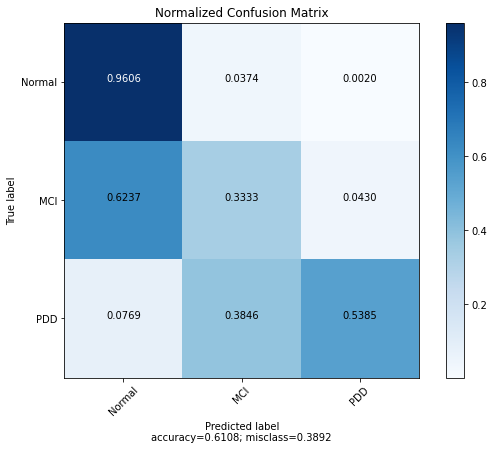

Epoch 1/50
2235/2235 [==============================] - 9s 3ms/step - loss: 0.3251 - custom_f12: 0.5355 - acc: 0.7777 - val_loss: 0.7805 - val_custom_f12: 0.7309 - val_acc: 0.8032

Epoch 00001: saving model to mymodel_1.h5

Epoch 00001: val_custom_f12 improved from -inf to 0.73092, saving model to best_model.h5

Testing loss: 0.6896438002586365, custom_f1: 0.8353952765464783, acc: 0.8538206219673157

Epoch 2/50
2235/2235 [==============================] - 7s 3ms/step - loss: 0.2144 - custom_f12: 0.7860 - acc: 0.8547 - val_loss: 0.7724 - val_custom_f12: 0.7751 - val_acc: 0.7992

Epoch 00002: saving model to mymodel_2.h5

Epoch 00002: val_custom_f12 improved from 0.73092 to 0.77510, saving model to best_model.h5

Testing loss: 0.6776365637779236, custom_f1: 0.8566058278083801, acc: 0.8621262311935425

Epoch 3/50
2235/2235 [==============================] - 7s 3ms/step - loss: 0.1937 - custom_f12: 0.8400 - acc: 0.8741 - val_loss: 0.7420 - val_custom_f12: 0.7992 - val_acc: 0.8032

Epoch 00

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

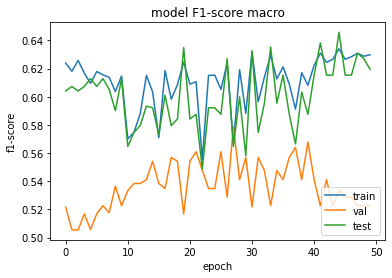

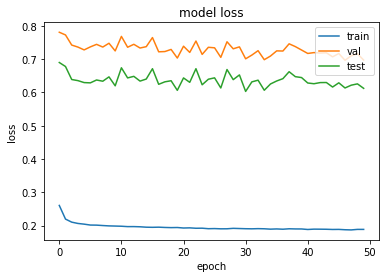

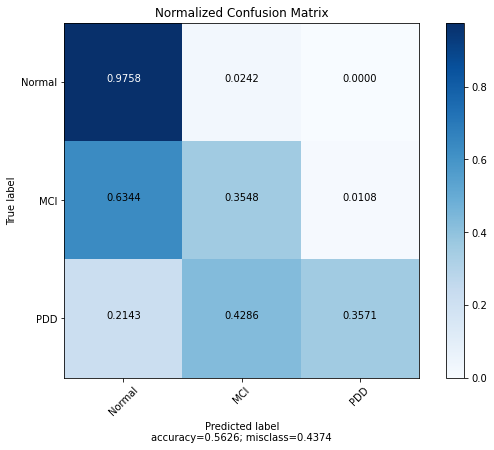

Epoch 1/50
2227/2227 [==============================] - 9s 3ms/step - loss: 0.3169 - custom_f12: 0.5855 - acc: 0.8028 - val_loss: 0.7383 - val_custom_f12: 0.7742 - val_acc: 0.8266

Epoch 00001: saving model to mymodel_1.h5

Epoch 00001: val_custom_f12 improved from -inf to 0.77419, saving model to best_model.h5

Testing loss: 0.7948025465011597, custom_f1: 0.8072738647460938, acc: 0.8003273606300354

Epoch 2/50
2227/2227 [==============================] - 6s 3ms/step - loss: 0.2298 - custom_f12: 0.7838 - acc: 0.8351 - val_loss: 0.6929 - val_custom_f12: 0.7742 - val_acc: 0.8387

Epoch 00002: saving model to mymodel_2.h5

Epoch 00002: val_custom_f12 did not improve from 0.77419

Testing loss: 0.739531397819519, custom_f1: 0.804781436920166, acc: 0.8379705548286438

Epoch 3/50
2227/2227 [==============================] - 6s 3ms/step - loss: 0.2258 - custom_f12: 0.7772 - acc: 0.8482 - val_loss: 0.7023 - val_custom_f12: 0.7742 - val_acc: 0.8387

Epoch 00003: saving model to mymodel_3.h5

Ep

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

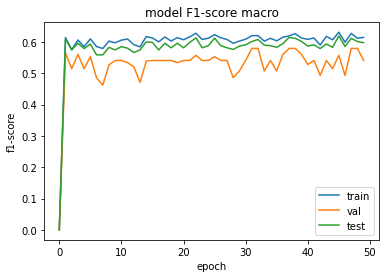

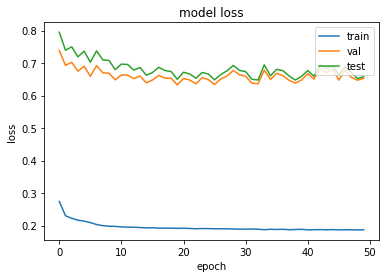

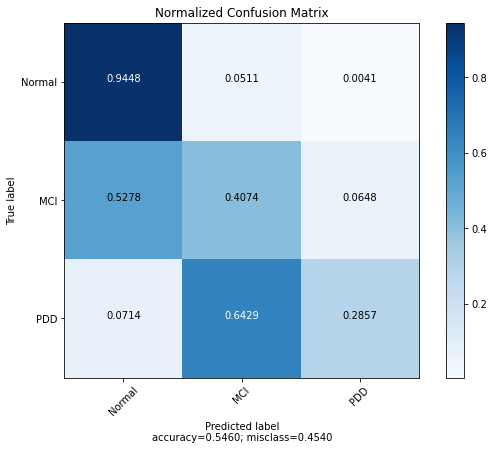

In [11]:

#split data into train, validation and test based on unique patient numbers
import random
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

patients_df=pd.DataFrame()
patients_df['unique']=patients
patients_df['diagnosis']=labels_true
patients_df=patients_df.sort_values(by="unique", ascending=True)
grouped_patients = patients_df.groupby("unique")
maximums = grouped_patients.max()
maximums = maximums.reset_index()
sss = StratifiedKFold(n_splits=5, random_state=0)

#pat=np.unique(np.asarray(patients))

#random.seed(500)
#random.shuffle(pat)
kfold = KFold(n_splits=5, shuffle=True)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
epoch=50
pat2=maximums['unique'].values
pat2_labels=maximums['diagnosis'].values
k1=0
for train_i, test_i in sss.split(maximums['unique'], maximums['diagnosis']):
  training_ind=pat2[train_i]
  test_ind=pat2[test_i]
  X_train=[]
  X_test=[]
  y_train=[]
  y_test=[]
  loss_test=[]
  f1_test=[]
  acc_test=[]
  y_test_true=[] #ot one-hot encoded done for easy usage
  y_train_true=[] #ot one-hot encoded done for easy usage
  for tr in training_ind:
    ind=[i for i, e in enumerate(patients) if e == tr]
    for j in ind:
      X_train.append(data[j])
      y_train.append(labels[j])
      y_train_true.append(labels_true[j])

  for te in test_ind:
    ind=[i for i, e in enumerate(patients) if e == te]
    for j in ind:
      X_test.append(data[j])
      y_test.append(labels[j])
      y_test_true.append(labels_true[j])

  temp_train=y_train
  X_train=np.asarray(X_train)
  X_test=np.asarray(X_test)
  #remove the visit index column for training. we will later need it for doing analysis at each visit)
  X_train1=X_train[:,:,0:9]
  X_test1=X_test[:,:,0:9]

  y_train=np.asarray(y_train)
  y_train_true=np.asarray(y_train_true)
  y_train=y_train.reshape(y_train.shape[0],1,3)

  y_test=np.asarray(y_test)
  y_test_true=np.asarray(y_test_true)
  y_test=y_test.reshape(y_test.shape[0],1,3)
  y_test_true=y_test_true.reshape(y_test_true.shape[0],1)
  y_train_true=y_train_true.reshape(y_train_true.shape[0],1)

  #performance at each visits test set
  visit_analysis=pd.DataFrame()
  visit_analysis['visit']=X_test[:,0,9]
  visit_analysis['current_cognition']=((X_test[:,0,6]*0)+(X_test[:,0,7]*2)+(X_test[:,0,8]*4))/2
  visit_analysis['next_cognition']=y_test_true

  #visit information whole dataset
  visit_total=pd.DataFrame()
  visit_total['visit']=np.concatenate((X_train[:,0,9],X_test[:,0,9]),axis=0)
  visit_total['current_cognition']=np.concatenate((((X_train[:,0,6]*0)+(X_train[:,0,7]*2)+(X_train[:,0,8]*4))/2,((X_test[:,0,6]*0)+(X_test[:,0,7]*2)+(X_test[:,0,8]*4))/2),axis=0)
  visit_total['next_cognition']=np.concatenate((y_train_true,y_test_true),axis=0)

  X_train2, X_valid1, y_train2, y_valid, y_train_true2, y_valid_true = train_test_split(X_train1, y_train, y_train_true,
                                                    stratify=y_train_true, 
                                                    test_size=0.1)


  # model
  model = Sequential()
  model.add(LSTM(8, activation='relu', return_sequences= True, input_shape=(1, params+3))) # 32 ,16-8
  #model.add(LSTM(8, activation='relu', return_sequences= True))
  model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-5),
    activity_regularizer=regularizers.l2(1e-4)))
  #model.add(Dense(3, activation='softmax'))
  es = EarlyStopping(monitor='val_custom_f12', mode='max', verbose=1, patience=150)
  mc_best = ModelCheckpoint('best_model.h5', monitor='val_custom_f12', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
  mc = ModelCheckpoint("mymodel_{epoch}.h5", monitor='val_loss', mode='min', verbose=1, save_weights_only=True)
  #weights for loss function
  weights1=np.array([1, 2, 2])

  #class_weights = class_weight.compute_class_weight('balanced',np.unique(np.ravel(y_train,order='C')),np.ravel(y_train,order='C'))
  sampleweights=class_weight.compute_sample_weight([{0: 1, 1: 0.4}, {0: 1, 1: 0.25}, {0: 1, 1: 0.65}], y_train2.reshape(y_train2.shape[0],3))

  model.compile(optimizer='adam', loss=weighted_categorical_crossentropy(weights1),metrics=[custom_f12,'acc'])
  
  with tf. device("gpu:0"):
    history = model.fit(X_train2, y_train2, epochs=epoch, validation_data=(X_valid1,y_valid), verbose=1,batch_size=1,sample_weight=sampleweights, callbacks=[es,mc,mc_best,TestCallback((X_test1, y_test))])#sample_weight=sampleweights  #add mc include this when we need to save all epochs
  model.load_weights('best_model.h5')
  

  k1=k1+1


  out_train = model.predict_classes(X_train1, batch_size=1)
  acc1_train.append((sum(out_train==y_train_true)/len(y_train_true)))
  f11_train.append(custom_f1(y_train_true, out_train))

  yhat = model.predict_classes(X_test1, batch_size=1)
  acc1_test.append((sum(yhat==y_test_true)/len(y_test_true)))
  f11_test.append(custom_f1(y_test_true, yhat))
  
  visit_analysis['predicted_cognition']=yhat
  #performance at 1st visit
  perfirst=visit_analysis.loc[visit_analysis.visit==0]
  acc1_test_first.append(sum(perfirst['next_cognition'].values==perfirst['predicted_cognition'].values)/(len(perfirst['next_cognition'])+0.001) )
  f11_test_first.append(custom_f1(perfirst['next_cognition'].values, perfirst['predicted_cognition'].values) )

  #performance at 2nd visit
  persecond=visit_analysis.loc[visit_analysis.visit==1]
  acc1_test_second.append(sum(persecond['next_cognition'].values==persecond['predicted_cognition'].values)/(len(persecond['next_cognition'])+0.001) )
  f11_test_second.append(custom_f1(persecond['next_cognition'].values, persecond['predicted_cognition'].values))
  
  #performance at 3rd visit
  perthird=visit_analysis.loc[visit_analysis.visit==2]
  acc1_test_third.append(sum(perthird['next_cognition'].values==perthird['predicted_cognition'].values)/(len(perthird['next_cognition'])+0.001) )
  f11_test_third.append(custom_f1(perthird['next_cognition'].values, perthird['predicted_cognition'].values) )
 
 #performance at 4th visit
  perfourth=visit_analysis.loc[visit_analysis.visit==3]
  acc1_test_fourth.append(sum(perfourth['next_cognition'].values==perfourth['predicted_cognition'].values)/(len(perfourth['next_cognition'])+0.001) )
  f11_test_fourth.append(custom_f1(perfourth['next_cognition'].values, perfourth['predicted_cognition'].values) )
  
 #performance at 5th visit
  perfifth=visit_analysis.loc[visit_analysis.visit==4]
  acc1_test_fifth.append(sum(perfifth['next_cognition'].values==perfifth['predicted_cognition'].values)/(len(perfifth['next_cognition'])+0.001) )
  f11_test_fifth.append(custom_f1(perfifth['next_cognition'].values, perfifth['predicted_cognition'].values) )
  
  #performance at 6th visit
  persixth=visit_analysis.loc[visit_analysis.visit==5]
  acc1_test_sixth.append(sum(persixth['next_cognition'].values==persixth['predicted_cognition'].values)/(len(persixth['next_cognition'])+0.001) )
  f11_test_sixth.append(custom_f1(persixth['next_cognition'].values, persixth['predicted_cognition'].values) )
  
  #performance at 7th visit
  perseventh=visit_analysis.loc[visit_analysis.visit==6]
  acc1_test_seventh.append(sum(perseventh['next_cognition'].values==perseventh['predicted_cognition'].values)/(len(perseventh['next_cognition'])+0.001) )
  f11_test_seventh.append(custom_f1(perseventh['next_cognition'].values, perseventh['predicted_cognition'].values) )


  #Predict the performance measure on those patients having change of state from viist
  change_cognition=visit_analysis[~(visit_analysis['current_cognition']==visit_analysis['next_cognition'])]
  statuschange0_1=change_cognition[(change_cognition['current_cognition']==0) & (change_cognition['next_cognition']==1)]
  acc1_statuschange0_1.append(sum(statuschange0_1['next_cognition'].values==statuschange0_1['predicted_cognition'].values)/(len(statuschange0_1['next_cognition'])+0.001) )
  f11_statuschange0_1.append(custom_f1(statuschange0_1['next_cognition'].values, statuschange0_1['predicted_cognition'].values) )

  statuschange0_2=change_cognition[(change_cognition['current_cognition']==0) & (change_cognition['next_cognition']==2)]
  acc1_statuschange0_2.append(sum(statuschange0_2['next_cognition'].values==statuschange0_2['predicted_cognition'].values)/(len(statuschange0_2['next_cognition'])+0.001) )
  f11_statuschange0_2.append(custom_f1(statuschange0_2['next_cognition'].values, statuschange0_2['predicted_cognition'].values) )

  statuschange1_2=change_cognition[(change_cognition['current_cognition']==1) & (change_cognition['next_cognition']==2)]
  acc1_statuschange1_2.append(sum(statuschange1_2['next_cognition'].values==statuschange1_2['predicted_cognition'].values)/(len(statuschange1_2['next_cognition'])+0.001) )
  f11_statuschange1_2.append(custom_f1(statuschange1_2['next_cognition'].values, statuschange1_2['predicted_cognition'].values) )

  statuschange1_0=change_cognition[(change_cognition['current_cognition']==1) & (change_cognition['next_cognition']==0)]
  acc1_statuschange1_0.append(sum(statuschange1_0['next_cognition'].values==statuschange1_0['predicted_cognition'].values)/(len(statuschange1_0['next_cognition'])+0.001) )
  f11_statuschange1_0.append(custom_f1(statuschange1_0['next_cognition'].values, statuschange1_0['predicted_cognition'].values) )

  statuschange2_1=change_cognition[(change_cognition['current_cognition']==2) & (change_cognition['next_cognition']==1)]
  acc1_statuschange2_1.append(sum(statuschange2_1['next_cognition'].values==statuschange2_1['predicted_cognition'].values)/(len(statuschange2_1['next_cognition'])+0.001) )
  f11_statuschange2_1.append(custom_f1(statuschange2_1['next_cognition'].values, statuschange2_1['predicted_cognition'].values) )
  train_loss_epoch=[]
  test_loss_epoch=[]
  valid_loss_epoch=[]
  train_f1_epoch=[]
  test_f1_epoch=[]
  valid_f1_epoch=[]  
  for m in range(epoch):
    st=str(m+1)
    var='mymodel_'+st+'.h5'
    model.load_weights(var)
    out_train_class = model.predict_classes(X_train2)
    out_train_prob = model.predict_proba(X_train2)
    loss_train_tmp = (y_train_true2-out_train_prob).sum()
    f1_train_tmp = custom_f1(y_train_true2, out_train_class)

    out_valid_class = model.predict_classes(X_valid1)
    out_valid_prob = model.predict_proba(X_valid1)
    loss_valid_tmp = (y_valid_true-out_valid_prob).sum()
    f1_valid_tmp = custom_f1(y_valid_true, out_valid_class)

    out_test_class = model.predict_classes(X_test1)
    out_test_prob = model.predict_proba(X_test1)
    loss_test_tmp = (y_test_true-out_test_prob).sum()
    f1_test_tmp = custom_f1(y_test_true, out_test_class)

    train_loss_epoch.append(loss_train_tmp)
    test_loss_epoch.append(loss_test_tmp)
    valid_loss_epoch.append(loss_valid_tmp)
    train_f1_epoch.append(f1_train_tmp)
    test_f1_epoch.append(f1_test_tmp)
    valid_f1_epoch.append(f1_valid_tmp)   
  #plt.plot(history.history['custom_f12'])#custom_f12
  #plt.plot(history.history['val_custom_f12']) #val_custom_f12
  #plt.title('model F1-score macro')
  #plt.ylabel('f1-score')
  #plt.xlabel('epoch')
  #plt.legend(['train', 'val'], loc='lower right')
  #plt.show()


  #plt.plot(f1_test)
  #plt.title('model F1-score macro')
  #plt.ylabel('f1-score')
  #plt.xlabel('epoch')
  #plt.legend(['test'], loc='lower right')
  #plt.show()

  plt.plot(train_f1_epoch) #custom_f12
  plt.plot(valid_f1_epoch) #val_custom_f12
  plt.plot(test_f1_epoch)
  plt.title('model F1-score macro')
  plt.ylabel('f1-score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val','test'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.plot(loss_test)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val', 'test'], loc='upper right')
  plt.show()

  cmatrix=confusion_matrix(y_test_true,yhat)
  csum=np.abs(cmatrix).sum(axis=1).reshape(3,1)
  plot_confusion_matrix(cm           = cmatrix/csum, 
                      normalize    = True,
                      target_names = ['Normal', 'MCI', 'PDD'],
                      title        = "Normalized Confusion Matrix")

In [12]:

print('training prediction accuracy and F1-score', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_train), np.std(acc1_train)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_train), np.std(f11_train)))
print('test prediction accuracy and F1-score', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test), np.std(acc1_test)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test), np.std(f11_test)))


training prediction accuracy and F1-score 0.86% (+/- 0.00%) and 0.59% (+/- 0.03%)
test prediction accuracy and F1-score 0.85% (+/- 0.01%) and 0.55% (+/- 0.03%)


In [ ]:
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
#performance at 1st visit
print('testing prediction accuracy and F1-score of 1st visits', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test_first), np.std(acc1_test_first)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test_first), np.std(f11_test_first)))
print('testing prediction accuracy and F1-score of 2nd visits', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test_second), np.std(acc1_test_second)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test_second), np.std(f11_test_second)))
print('testing prediction accuracy and F1-score of 3rd visits', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test_third), np.std(acc1_test_third)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test_third), np.std(f11_test_third)))
print('testing prediction accuracy and F1-score of 4th visits', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test_fourth), np.std(acc1_test_fourth)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test_fourth), np.std(f11_test_fourth)))
print('testing prediction accuracy and F1-score of 5th visits', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test_fifth), np.std(acc1_test_fifth)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test_fifth), np.std(f11_test_fifth)))
print('testing prediction accuracy and F1-score of 6th visits', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test_sixth), np.std(acc1_test_sixth)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test_sixth), np.std(f11_test_sixth)))
print('testing prediction accuracy and F1-score of 7th visits', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_test_seventh), np.std(acc1_test_seventh)), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_test_seventh), np.std(f11_test_seventh)))

testing prediction accuracy and F1-score of 1st visits 0.79% (+/- 0.04%) and 0.48% (+/- 0.06%)
testing prediction accuracy and F1-score of 2nd visits 0.75% (+/- 0.04%) and 0.51% (+/- 0.05%)
testing prediction accuracy and F1-score of 3rd visits 0.74% (+/- 0.04%) and 0.55% (+/- 0.05%)
testing prediction accuracy and F1-score of 4th visits 0.70% (+/- 0.06%) and 0.58% (+/- 0.07%)
testing prediction accuracy and F1-score of 5th visits 0.71% (+/- 0.07%) and 0.52% (+/- 0.11%)
testing prediction accuracy and F1-score of 6th visits 0.70% (+/- 0.07%) and 0.61% (+/- 0.08%)
testing prediction accuracy and F1-score of 7th visits 0.71% (+/- 0.10%) and 0.67% (+/- 0.13%)


In [ ]:
import matplotlib.pyplot as plt
y1=np.array([np.mean(acc1_test_first), np.mean(acc1_test_second), np.mean(acc1_test_third), np.mean(acc1_test_fourth), np.mean(acc1_test_fifth), np.mean(acc1_test_sixth), np.mean(acc1_test_seventh)])
y2=np.array([np.mean(f11_test_first), np.mean(f11_test_second), np.mean(f11_test_third), np.mean(f11_test_fourth), np.mean(f11_test_fifth), np.mean(f11_test_sixth), np.mean(f11_test_seventh)])
y1_std=np.array([np.std(acc1_test_first), np.std(acc1_test_second), np.std(acc1_test_third), np.std(acc1_test_fourth), np.std(acc1_test_fifth), np.std(acc1_test_sixth), np.std(acc1_test_seventh)])
y2_std=np.array([np.std(f11_test_first), np.std(f11_test_second), np.std(f11_test_third), np.std(f11_test_fourth), np.std(f11_test_fifth), np.std(f11_test_sixth), np.std(f11_test_seventh)])
x = np.arange(1, 8, 1)
plt.errorbar(x, y1, yerr=y1_std)
plt.errorbar(x, y2, yerr=y2_std)
plt.legend(['accuracy','F1-score'])
plt.xlabel('visit number')
plt.ylabel('score')

In [13]:
#Predict the performance measure on those patients having change of state from viist
print('training prediction accuracy and F1-score of status change Normal to MCI', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_statuschange0_1)*100, np.std(acc1_statuschange0_1)*100), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_statuschange0_1)*100, np.std(f11_statuschange0_1)*100))
print('training prediction accuracy and F1-score of status change Normal to PDD', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_statuschange0_2)*100, np.std(acc1_statuschange0_2)*100), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_statuschange0_2)*100, np.std(f11_statuschange0_2)*100))
print('training prediction accuracy and F1-score of status change MCI to PDD', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_statuschange1_2)*100, np.std(acc1_statuschange1_2)*100), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_statuschange1_2)*100, np.std(f11_statuschange1_2)*100))
print('training prediction accuracy and F1-score of status change MCI to Normal', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_statuschange1_0)*100, np.std(acc1_statuschange1_0)*100), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_statuschange1_0)*100, np.std(f11_statuschange1_0)*100))
print('training prediction accuracy and F1-score of status change PDD to MCI', "%.2f%% (+/- %.2f%%)" % (np.mean(acc1_statuschange2_1)*100, np.std(acc1_statuschange2_1)*100), 'and', "%.2f%% (+/- %.2f%%)" % (np.mean(f11_statuschange2_1)*100, np.std(f11_statuschange2_1)*100))


training prediction accuracy and F1-score of status change Normal to MCI 0.56% (+/- 0.85%) and 1.10% (+/- 1.68%)
training prediction accuracy and F1-score of status change Normal to PDD 0.00% (+/- 0.00%) and 0.00% (+/- 0.00%)
training prediction accuracy and F1-score of status change MCI to PDD 14.75% (+/- 11.89%) and 95.23% (+/- 4.82%)
training prediction accuracy and F1-score of status change MCI to Normal 42.99% (+/- 18.67%) and 0.00% (+/- 0.00%)
training prediction accuracy and F1-score of status change PDD to MCI 14.99% (+/- 24.09%) and 100.00% (+/- 0.00%)


In [ ]:
change_cognition_total=visit_total[~(visit_total['current_cognition']==visit_total['next_cognition'])]
statuschange0_1_total=change_cognition_total[(change_cognition_total['current_cognition']==0) & (change_cognition_total['next_cognition']==1)]
statuschange0_2_total=change_cognition_total[(change_cognition_total['current_cognition']==0) & (change_cognition_total['next_cognition']==2)]
statuschange1_2_total=change_cognition_total[(change_cognition_total['current_cognition']==1) & (change_cognition_total['next_cognition']==2)]
statuschange1_0_total=change_cognition_total[(change_cognition_total['current_cognition']==1) & (change_cognition_total['next_cognition']==0)]
statuschange2_1_total=change_cognition_total[(change_cognition_total['current_cognition']==2) & (change_cognition_total['next_cognition']==1)]
print('samples of status change Normal to MCI', len(statuschange0_1_total))
print('samples of status change Normal to PDD', len(statuschange0_2_total))
print('samples of status change MCI to PDD', len(statuschange1_2_total))
print('samples of status change MCI to Normal', len(statuschange1_0_total))
print('samples of status change PDD to MCI', len(statuschange2_1_total))

samples of status change Normal to MCI 238
samples of status change Normal to PDD 4
samples of status change MCI to PDD 44
samples of status change MCI to Normal 153
samples of status change PDD to MCI 13


In [ ]:
#manual validation set

#split data into train, validation and test based on unique patient numbers
import random
pat=np.unique(np.asarray(patients))
random.seed(500)
random.shuffle(pat)
training_ind, test_ind = pat[:round(0.70*len(pat))], pat[round(0.70*len(pat)):]
#validation_ind=test_ind[:round(0.5*len(test_ind))]
#test_ind=test_ind[round(0.5*len(test_ind)):]
validation_ind=np.random.choice(test_ind,np.int(len(test_ind)/2))
test_ind = np.array(list(filter(lambda x: x not in validation_ind, test_ind)))
X_train=[]
X_valid=[]
X_test=[]
y_train=[]
y_valid=[]
y_test=[]
y_test_true=[] #ot one-hot encoded done for easy usage
y_train_true=[] #ot one-hot encoded done for easy usage
y_valid_true=[] #ot one-hot encoded done for easy usage
for tr in training_ind:
  ind=[i for i, e in enumerate(patients) if e == tr]
  for j in ind:
    X_train.append(data[j])
    y_train.append(labels[j])
    y_train_true.append(labels_true[j])

for te in test_ind:
  ind=[i for i, e in enumerate(patients) if e == te]
  for j in ind:
    X_test.append(data[j])
    y_test.append(labels[j])
    y_test_true.append(labels_true[j])

for va in validation_ind:
  ind=[i for i, e in enumerate(patients) if e == va]
  for j in ind:
    X_valid.append(data[j])
    y_valid.append(labels[j])
    y_valid_true.append(labels_true[j])


temp_train=y_train
X_train=np.asarray(X_train)
X_valid=np.asarray(X_valid)
X_test=np.asarray(X_test)
#remove the visit index column for training. we will later need it for doing analysis at each visit)
X_train1=X_train[:,:,0:9]
X_valid1=X_valid[:,:,0:9]
X_test1=X_test[:,:,0:9]

y_train=np.asarray(y_train)
y_train_true=np.asarray(y_train_true)
y_train=y_train.reshape(y_train.shape[0],1,3)
y_valid=np.asarray(y_valid)
y_valid_true=np.asarray(y_valid_true)
y_valid=y_valid.reshape(y_valid.shape[0],1,3)
y_test=np.asarray(y_test)
y_test_true=np.asarray(y_test_true)
y_test=y_test.reshape(y_test.shape[0],1,3)
y_test_true=y_test_true.reshape(y_test_true.shape[0],1)
y_valid_true=y_valid_true.reshape(y_valid_true.shape[0],1)
y_train_true=y_train_true.reshape(y_train_true.shape[0],1)


In [ ]:
C = np.array(list(filter(lambda x: x not in validation_ind, test_ind)))

In [ ]:
len(C)

182

In [ ]:
np.shape(np.where(np.asarray(y_valid_true)==0))[1]
#2041+122+37
#len(labels_true)

379

In [ ]:

from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',np.unique(np.ravel(y_train,order='C')),np.ravel(y_train,order='C'))
sampleweights=class_weight.compute_sample_weight([{0: 1, 1: 0.1}, {0: 1, 1: 0.25}, {0: 1, 1: 0.94}], y_train.reshape(y_train.shape[0],3))
weights1=np.array([1, 5, 10])

In [ ]:
# fit sequential models
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
tf. device("gpu:1")
from keras.metrics import Precision, Recall
#yhat = model.predict_classes(X_test1)
#yhat = model.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import pylab as pl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences= True, input_shape=(1, params+3))) # 32 ,16-8
model.add(LSTM(8, activation='relu', return_sequences= True))
model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-5),
    activity_regularizer=regularizers.l2(1e-4)))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)
model.compile(optimizer='adam', loss=weighted_categorical_crossentropy(weights1),metrics=[f1_m,'acc'])

acc1_train = 0
f11_train = 0

acc1_valid = 0
f11_valid = 0

acc1_test = 0
f11_test = 0
acc1_test_first=0
f11_test_first=0
acc1_test_second=0
f11_test_second=0
acc1_test_third=0
f11_test_third=0
acc1_test_fourth=0
f11_test_fourth=0
acc1_test_fifth=0
f11_test_fifth=0
acc1_test_sixth=0
f11_test_sixth=0
acc1_test_seventh=0
f11_test_seventh=0

acc1_statuschange0_1=0
f11_statuschange0_1=0
acc1_statuschange0_2=0
f11_statuschange0_2=0
acc1_statuschange1_2=0
f11_statuschange1_2=0
acc1_statuschange1_0=0
f11_statuschange1_0=0
acc1_statuschange2_1=0
f11_statuschange2_1=0
n=1

#performance at each visits test set
visit_analysis=pd.DataFrame()
visit_analysis['visit']=X_test[:,0,9]
visit_analysis['current_cognition']=((X_test[:,0,6]*0)+(X_test[:,0,7]*2)+(X_test[:,0,8]*4))/2
visit_analysis['next_cognition']=y_test_true

#visit information whole dataset
visit_total=pd.DataFrame()
visit_total['visit']=np.concatenate((X_train[:,0,9],X_valid[:,0,9],X_test[:,0,9]),axis=0)
visit_total['current_cognition']=np.concatenate((((X_train[:,0,6]*0)+(X_train[:,0,7]*2)+(X_train[:,0,8]*4))/2,((X_valid[:,0,6]*0)+(X_valid[:,0,7]*2)+(X_valid[:,0,8]*4))/2,((X_test[:,0,6]*0)+(X_test[:,0,7]*2)+(X_test[:,0,8]*4))/2),axis=0)
visit_total['next_cognition']=np.concatenate((y_train_true,y_valid_true,y_test_true),axis=0)

for i in range(n):
  history = model.fit(X_train1, y_train, epochs=500, validation_data=(X_valid1,y_valid), verbose=1,batch_size=1,sample_weight=sampleweights, callbacks=[es,mc])#sample_weight=sampleweights
  model.load_weights('best_model.h5')
  out_train = model.predict_classes(X_train1)
  acc1_train = acc1_train+(sum(out_train==y_train_true)/len(y_train_true))
  f11_train = f11_train+f1_score(y_train_true, out_train, average='macro')
  out_valid = model.predict_classes(X_valid1)
  acc1_valid = acc1_valid+(sum(out_valid==y_valid_true)/len(y_valid_true))
  f11_valid = f11_valid+f1_score(y_valid_true, out_valid, average='macro')
  yhat = model.predict_classes(X_test1)
  acc1_test = acc1_test+(sum(yhat==y_test_true)/len(y_test_true))
  f11_test = f11_test+f1_score(y_test_true, yhat, average='macro')
  visit_analysis['predicted_cognition']=yhat
  #performance at 1st visit
  perfirst=visit_analysis.loc[visit_analysis.visit==0]
  acc1_test_first = sum(perfirst['next_cognition'].values==perfirst['predicted_cognition'].values)/len(perfirst['next_cognition']) + acc1_test_first
  f11_test_first = f1_score(perfirst['next_cognition'].values, perfirst['predicted_cognition'].values, average='macro') + f11_test_first

  #performance at 2nd visit
  persecond=visit_analysis.loc[visit_analysis.visit==1]
  acc1_test_second = sum(persecond['next_cognition'].values==persecond['predicted_cognition'].values)/len(persecond['next_cognition']) +acc1_test_second
  f11_test_second = f1_score(persecond['next_cognition'].values, persecond['predicted_cognition'].values, average='macro')+f11_test_second
  
  #performance at 3rd visit
  perthird=visit_analysis.loc[visit_analysis.visit==2]
  acc1_test_third = sum(perthird['next_cognition'].values==perthird['predicted_cognition'].values)/len(perthird['next_cognition']) + acc1_test_third
  f11_test_third = f1_score(perthird['next_cognition'].values, perthird['predicted_cognition'].values, average='macro') +f11_test_third
 
 #performance at 4th visit
  perfourth=visit_analysis.loc[visit_analysis.visit==3]
  acc1_test_fourth = sum(perfourth['next_cognition'].values==perfourth['predicted_cognition'].values)/len(perfourth['next_cognition']) + acc1_test_fourth
  f11_test_fourth = f1_score(perfourth['next_cognition'].values, perfourth['predicted_cognition'].values, average='macro') + f11_test_fourth
  
 #performance at 5th visit
  perfifth=visit_analysis.loc[visit_analysis.visit==4]
  acc1_test_fifth = sum(perfifth['next_cognition'].values==perfifth['predicted_cognition'].values)/len(perfifth['next_cognition']) + acc1_test_fifth
  f11_test_fifth = f1_score(perfifth['next_cognition'].values, perfifth['predicted_cognition'].values, average='macro') + f11_test_fifth
  
  #performance at 6th visit
  persixth=visit_analysis.loc[visit_analysis.visit==5]
  acc1_test_sixth = sum(persixth['next_cognition'].values==persixth['predicted_cognition'].values)/len(persixth['next_cognition']) + acc1_test_sixth
  f11_test_sixth = f1_score(persixth['next_cognition'].values, persixth['predicted_cognition'].values, average='macro') + f11_test_sixth
  
  #performance at 7th visit
  perseventh=visit_analysis.loc[visit_analysis.visit==6]
  acc1_test_seventh = sum(perseventh['next_cognition'].values==perseventh['predicted_cognition'].values)/len(perseventh['next_cognition']) + acc1_test_seventh
  f11_test_seventh = f1_score(perseventh['next_cognition'].values, perseventh['predicted_cognition'].values, average='macro') + f11_test_seventh


  #Predict the performance measure on those patients having change of state from viist
  change_cognition=visit_analysis[~(visit_analysis['current_cognition']==visit_analysis['next_cognition'])]
  statuschange0_1=change_cognition[(change_cognition['current_cognition']==0) & (change_cognition['next_cognition']==1)]
  acc1_statuschange0_1 = sum(statuschange0_1['next_cognition'].values==statuschange0_1['predicted_cognition'].values)/(len(statuschange0_1['next_cognition'])+0.001) + acc1_statuschange0_1
  f11_statuschange0_1 = f1_score(statuschange0_1['next_cognition'].values, statuschange0_1['predicted_cognition'].values, average='macro') + f11_statuschange0_1

  statuschange0_2=change_cognition[(change_cognition['current_cognition']==0) & (change_cognition['next_cognition']==2)]
  acc1_statuschange0_2 = sum(statuschange0_2['next_cognition'].values==statuschange0_2['predicted_cognition'].values)/(len(statuschange0_2['next_cognition'])+0.001) + acc1_statuschange0_2
  f11_statuschange0_2 = f1_score(statuschange0_2['next_cognition'].values, statuschange0_2['predicted_cognition'].values, average='macro') + f11_statuschange0_2

  statuschange1_2=change_cognition[(change_cognition['current_cognition']==1) & (change_cognition['next_cognition']==2)]
  acc1_statuschange1_2 = sum(statuschange1_2['next_cognition'].values==statuschange1_2['predicted_cognition'].values)/(len(statuschange1_2['next_cognition'])+0.001) + acc1_statuschange1_2
  f11_statuschange1_2 = f1_score(statuschange1_2['next_cognition'].values, statuschange1_2['predicted_cognition'].values, average='macro') + f11_statuschange1_2

  statuschange1_0=change_cognition[(change_cognition['current_cognition']==1) & (change_cognition['next_cognition']==0)]
  acc1_statuschange1_0 = sum(statuschange1_0['next_cognition'].values==statuschange1_0['predicted_cognition'].values)/(len(statuschange1_0['next_cognition'])+0.001) + acc1_statuschange1_0
  f11_statuschange1_0 = f1_score(statuschange1_0['next_cognition'].values, statuschange1_0['predicted_cognition'].values, average='macro') + f11_statuschange1_0

  statuschange2_1=change_cognition[(change_cognition['current_cognition']==2) & (change_cognition['next_cognition']==1)]
  acc1_statuschange2_1 = sum(statuschange2_1['next_cognition'].values==statuschange2_1['predicted_cognition'].values)/(len(statuschange2_1['next_cognition'])+0.001) + acc1_statuschange2_1
  f11_statuschange2_1 = f1_score(statuschange2_1['next_cognition'].values, statuschange2_1['predicted_cognition'].values, average='macro') + f11_statuschange2_1

acc1_train = acc1_train/n
f11_train = f11_train/n

acc1_valid = acc1_valid/n
f11_valid = f11_valid/n

acc1_test = acc1_test/n
f11_test = f11_test/n

acc1_test_first=acc1_test_first/n
f11_test_first=f11_test_first/n
acc1_test_second=acc1_test_second/n
f11_test_second=f11_test_second/n
acc1_test_third=acc1_test_third/n
f11_test_third=f11_test_third/n
acc1_test_fourth=acc1_test_fourth/n
f11_test_fourth=f11_test_fourth/n
acc1_test_fifth=acc1_test_fifth/n
f11_test_fifth=f11_test_fifth/n
acc1_test_sixth=acc1_test_sixth/n
f11_test_sixth=f11_test_sixth/n
acc1_test_seventh=acc1_test_seventh/n
f11_test_seventh=f11_test_seventh/n
acc1_statuschange0_1=acc1_statuschange0_1/n
f11_statuschange0_1=f11_statuschange0_1/n
acc1_statuschange0_2=acc1_statuschange0_2/n
f11_statuschange0_2=f11_statuschange0_2/n
acc1_statuschange1_2=acc1_statuschange1_2/n
f11_statuschange1_2=f11_statuschange1_2/n
acc1_statuschange1_0=acc1_statuschange1_0/n
f11_statuschange1_0=f11_statuschange1_0/n
acc1_statuschange2_1=acc1_statuschange2_1/n
f11_statuschange2_1=f11_statuschange2_1/n

Epoch 1/500
2161/2161 [==============================] - 38s 6ms/step - loss: 0.1308 - f1_m: 0.5407 - acc: 0.8215 - val_loss: 0.4839 - val_f1_m: 0.7768 - val_acc: 0.8326

Epoch 00001: val_f1_m improved from -inf to 0.77682, saving model to best_model.h5
Epoch 2/500
2161/2161 [==============================] - 12s 6ms/step - loss: 0.1094 - f1_m: 0.7625 - acc: 0.8397 - val_loss: 0.4174 - val_f1_m: 0.7768 - val_acc: 0.8326

Epoch 00002: val_f1_m did not improve from 0.77682
Epoch 3/500
1550/2161 [====================>.........] - ETA: 3s - loss: 0.1112 - f1_m: 0.7493 - acc: 0.8340

KeyboardInterrupt: ignored

481

In [ ]:
from collections import Counter
print(Counter(perfirst['next_cognition'].values))
print(Counter(persecond['next_cognition'].values))
print(Counter(perthird['next_cognition'].values))
print(Counter(perfourth['next_cognition'].values))
print(Counter(perfifth['next_cognition'].values))
print(Counter(persixth['next_cognition'].values))
print(Counter(perseventh['next_cognition'].values))

Counter({0.0: 125, 1.0: 17, 2.0: 3})
Counter({0.0: 99, 1.0: 11, 2.0: 3})
Counter({0.0: 71, 1.0: 10, 2.0: 2})
Counter({0.0: 45, 1.0: 10, 2.0: 1})
Counter({0.0: 28, 1.0: 7, 2.0: 3})
Counter({0.0: 19, 1.0: 3, 2.0: 1})
Counter({0.0: 3, 1.0: 2})


In [ ]:
perfirst_total=visit_total.loc[visit_total.visit==0]
persecond_total=visit_total.loc[visit_total.visit==1]
perthird_total=visit_total.loc[visit_total.visit==2]
perfourth_total=visit_total.loc[visit_total.visit==3]
perfifth_total=visit_total.loc[visit_total.visit==4]
persixth_total=visit_total.loc[visit_total.visit==5]
perseventh_total=visit_total.loc[visit_total.visit==6]
from collections import Counter
print(Counter(perfirst_total['next_cognition'].values))
print(Counter(persecond_total['next_cognition'].values))
print(Counter(perthird_total['next_cognition'].values))
print(Counter(perfourth_total['next_cognition'].values))
print(Counter(perfifth_total['next_cognition'].values))
print(Counter(persixth_total['next_cognition'].values))
print(Counter(perseventh_total['next_cognition'].values))

Counter({0.0: 834, 1.0: 122, 2.0: 14})
Counter({0.0: 594, 1.0: 106, 2.0: 15})
Counter({0.0: 444, 1.0: 86, 2.0: 13})
Counter({0.0: 313, 1.0: 72, 2.0: 9})
Counter({0.0: 197, 1.0: 43, 2.0: 12})
Counter({0.0: 121, 1.0: 37, 2.0: 9})
Counter({0.0: 30, 1.0: 11, 2.0: 4})


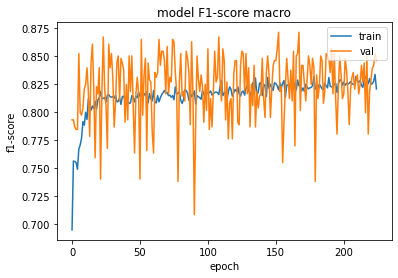

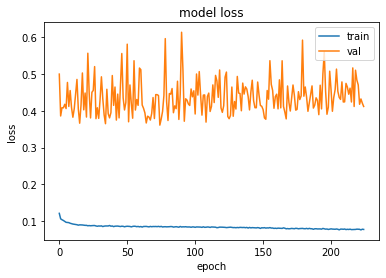

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F1-score macro')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:

#out_train = model.predict_classes(X_train1)
#acc1_train = sum(out_train==y_train_true)/len(y_train_true)
#f11_train = f1_score(y_train_true, out_train, average='macro')
print('training prediction accuracy and F1-score', acc1_train, 'and', f11_train)

#out_valid = model.predict_classes(X_valid1)
#acc1_valid = sum(out_valid==y_valid_true)/len(y_valid_true)
#f11_valid = f1_score(y_valid_true, out_valid, average='macro')
print('validation prediction accuracy and F1-score', acc1_valid, 'and', f11_valid)

#acc1_test = sum(yhat==y_test_true)/len(y_test_true)
#f11_test = f1_score(y_test_true, yhat, average='macro')
print('test prediction accuracy and F1-score', acc1_test, 'and', f11_test)


training prediction accuracy and F1-score [0.85701064] and 0.6815679998168883
validation prediction accuracy and F1-score [0.86697248] and 0.47361431467113996
test prediction accuracy and F1-score [0.85185185] and 0.7098455850332873


In [ ]:

#performance at 1st visit
print('training prediction accuracy and F1-score of 1st visits', acc1_test_first, 'and', f11_test_first)
print('training prediction accuracy and F1-score of 1st visits', acc1_test_second, 'and', f11_test_second)
print('training prediction accuracy and F1-score of 2nd visits', acc1_test_third, 'and', f11_test_third)
print('training prediction accuracy and F1-score of 3rd visits', acc1_test_fourth, 'and', f11_test_fourth)
print('training prediction accuracy and F1-score of 4th visits', acc1_test_fifth, 'and', f11_test_fifth)
print('training prediction accuracy and F1-score of 5th visits', acc1_test_sixth, 'and', f11_test_sixth)
print('training prediction accuracy and F1-score of 6th visits', acc1_test_seventh, 'and', f11_test_seventh)

training prediction accuracy and F1-score of 1st visits 0.8982035928143712 and 0.7501277139208175
training prediction accuracy and F1-score of 1st visits 0.8870967741935484 and 0.7941920729644515
training prediction accuracy and F1-score of 2nd visits 0.8469387755102041 and 0.8076537767982369
training prediction accuracy and F1-score of 3rd visits 0.7638888888888888 and 0.6162452107279693
training prediction accuracy and F1-score of 4th visits 0.7872340425531915 and 0.611111111111111
training prediction accuracy and F1-score of 5th visits 0.8076923076923077 and 0.48181818181818176
training prediction accuracy and F1-score of 6th visits 0.6666666666666666 and 0.29629629629629634


Text(0, 0.5, 'score')

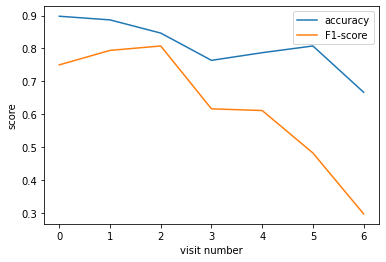

In [ ]:
import matplotlib.pyplot as plt
y1=[acc1_test_first, acc1_test_second, acc1_test_third, acc1_test_fourth, acc1_test_fifth, acc1_test_sixth, acc1_test_seventh]
y2=[f11_test_first, f11_test_second, f11_test_third, f11_test_fourth, f11_test_fifth, f11_test_sixth, f11_test_seventh]
plt.plot(y1)
plt.plot(y2)
plt.legend(['accuracy','F1-score'])
plt.xlabel('visit number')
plt.ylabel('score')

In [ ]:
#Predict the performance measure on those patients having change of state from viist
print('training prediction accuracy and F1-score of status change Normal to MCI', acc1_statuschange0_1, 'and', f11_statuschange0_1)
print('training prediction accuracy and F1-score of status change Normal to PDD', acc1_statuschange0_2, 'and', f11_statuschange0_2)
print('training prediction accuracy and F1-score of status change MCI to PDD', acc1_statuschange1_2, 'and', f11_statuschange1_2)
print('training prediction accuracy and F1-score of status change MCI to Normal', acc1_statuschange1_0, 'and', f11_statuschange1_0)
print('training prediction accuracy and F1-score of status change PDD to MCI', acc1_statuschange2_1, 'and', f11_statuschange2_1)


training prediction accuracy and F1-score of status change Normal to MCI 0.09523582771838766 and 0.08695652173913042
training prediction accuracy and F1-score of status change Normal to PDD 0.0 and 0.0
training prediction accuracy and F1-score of status change MCI to PDD 0.33327778703549404 and 0.16666666666666666
training prediction accuracy and F1-score of status change MCI to Normal 0.07692011845698242 and 0.07142857142857144
training prediction accuracy and F1-score of status change PDD to MCI 0.0 and 0.0


In [ ]:
change_cognition_total=visit_total[~(visit_total['current_cognition']==visit_total['next_cognition'])]
statuschange0_1_total=change_cognition_total[(change_cognition_total['current_cognition']==0) & (change_cognition_total['next_cognition']==1)]
statuschange0_2_total=change_cognition_total[(change_cognition_total['current_cognition']==0) & (change_cognition_total['next_cognition']==2)]
statuschange1_2_total=change_cognition_total[(change_cognition_total['current_cognition']==1) & (change_cognition_total['next_cognition']==2)]
statuschange1_0_total=change_cognition_total[(change_cognition_total['current_cognition']==1) & (change_cognition_total['next_cognition']==0)]
statuschange2_1_total=change_cognition_total[(change_cognition_total['current_cognition']==2) & (change_cognition_total['next_cognition']==1)]
print('samples of status change Normal to MCI', len(statuschange0_1_total))
print('samples of status change Normal to PDD', len(statuschange0_2_total))
print('samples of status change MCI to PDD', len(statuschange1_2_total))
print('samples of status change MCI to Normal', len(statuschange1_0_total))
print('samples of status change PDD to MCI', len(statuschange2_1_total))

samples of status change Normal to MCI 245
samples of status change Normal to PDD 4
samples of status change MCI to PDD 44
samples of status change MCI to Normal 156
samples of status change PDD to MCI 13


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

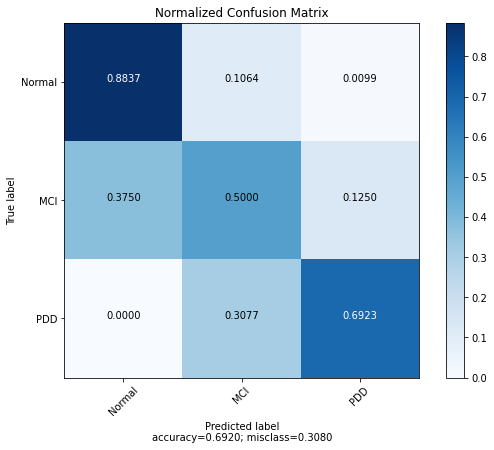

In [ ]:
cmatrix=confusion_matrix(y_test_true,yhat)
csum=np.abs(cmatrix).sum(axis=1).reshape(3,1)
plot_confusion_matrix(cm           = cmatrix/csum, 
                      normalize    = True,
                      target_names = ['Normal', 'MCI', 'PDD'],
                      title        = "Normalized Confusion Matrix")